In [80]:
!pip install nltk
!pip install -q wordcloud
!pip install matplotlib
!pip install vaderSentiment
!pip install NRCLex
!pip install seaborn
!pip install tensorflow
!pip install keras
!pip install scikit-learn
!pip install pydot


  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7f/90/c9b51f3cdff89cd8f93382060330f43d1af098a6624cff439e700791e922/pydot-2.0.0-py3-none-any.whl.metadata


In [98]:

!pip install pydot
!pip install pydotplus
!pip install graphviz

     ---------------------------------------- 0.0/278.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/278.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/278.7 kB ? eta -:--:--
     ----- ------------------------------- 41.0/278.7 kB 245.8 kB/s eta 0:00:01
     -------------- --------------------- 112.6/278.7 kB 547.6 kB/s eta 0:00:01
     -------------------------------------- 278.7/278.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24578 sha256=2202a8d0b85715caaa083180167b8a7696bd309de2e078cbb664231f16a75eb7
  Stored in directory: c:\users\jneig\appdata\local\pip\cache\wheels\bd\ce\e8\ff9d9c699514922f57caa22fbd55b0a32761114b4c4acc9e03
Successfully built pydotplus
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff46780

# Import the Dataset

In [62]:
from nrclex import NRCLex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keras.src.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.src.utils import pad_sequences
from keras.models import Sequential
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import DataFrame as df
import matplotlib.pyplot as mp




In [ ]:
df1 = df.copy();

df1.drop(columns=['text'], inplace=True)

plt.figure(figsize=(15, 15))
# plotting correlation heatmap 
dataplot = sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap 
mp.show()

In [4]:
stop = stopwords.words('english')

df = pd.read_csv("./datasets/train2Data.csv", encoding="utf-8", sep=',')

df.rename(columns={'Tweets': 'text', ' Label': 'label'}, inplace=True)
df['Message Size'] = df['text'].apply(lambda x: len(x))

#Remove stopwords from the dataset
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in ['amp', 'quot']]))

analyzer = SentimentIntensityAnalyzer()

print("Getting Fear")
df['fear'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('fear', 0))

print("Getting Anger")
df['anger'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('anger', 0))

print("Getting Anticipation")
df['anticipation'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('anticipation', 0))

print("Getting Trust")
df['trust'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('trust', 0))

print("Getting Surprise")
df['surprise'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('surprise', 0))

print("Getting Positive")
df['positive'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('positive', 0))

print("Getting Negative")
df['negative'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('negative', 0))

print("Getting Sadness")
df['sadness'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('sadness', 0))

print("Getting Disgust")
df['disgust'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('disgust', 0))

print("Getting Joy")
df['joy'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('joy', 0))

for index, row in df.iterrows():
    sentence = row['text']
    sentiment = analyzer.polarity_scores(sentence)

    df.at[index, 'negative'] = sentiment['neg']
    df.at[index, 'neutral'] = sentiment['neu']
    df.at[index, 'positive'] = sentiment['pos']
    df.at[index, 'compound'] = sentiment['compound']

Getting Fear
Getting Anger
Getting Anticipation
Getting Trust
Getting Surprise
Getting Positive
Getting Negative
Getting Sadness
Getting Disgust
Getting Joy


In [29]:
max_fatures = 1000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X_text = tokenizer.texts_to_sequences(df['text'].values)
X_text = pad_sequences(X_text)

X_attr = df.loc[:, df.columns != 'text']
X_attr = X_attr.drop('label', axis=1)
X_attr.head()

X_train, X_test, X_train_attr, X_test_attr, Y_train, Y_test = train_test_split(X_text, X_attr, df['label'],
                                                                               test_size=0.5)

# Basic Sequential Model

In [262]:
from keras.src.layers import Dropout, BatchNormalization
from keras.layers import Dense, Embedding, Input

embedding_dim = 64

x = Sequential()

x.add(Input(shape=(X_text.shape[1],)))
x.add(Embedding(max_fatures, embedding_dim, input_length=X_text.shape[1]))
x.add(Dense(128, activation='relu'))
x.add(BatchNormalization())
x.add(Dropout(0.5))
x.add(Dense(8, activation="relu"))
x.add(Dropout(0.2))
x.add(Dense(1, activation="sigmoid"))

x.compile(optimizer="adam", loss='binary_crossentropy', metrics='accuracy')

H = x.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=30,
          verbose=1, batch_size=16)


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 36, 128)           256000    
                                                                 
 dense_75 (Dense)            (None, 36, 16)            2064      
                                                                 
 dense_76 (Dense)            (None, 36, 1)             17        
                                                                 
Total params: 258081 (1008.13 KB)
Trainable params: 258081 (1008.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/7
635/775 [=======================>......] - ETA: 0s - loss: 0.6432 - accuracy: 0.5910

KeyboardInterrupt: 

# Hybrid Model Accepting Attribute Data

In [109]:
from keras.src.optimizers import Adam

from keras.src.layers import concatenate, Dropout, Flatten, BatchNormalization
from keras.layers import Dense, Embedding, Input
from keras.models import Model

embedding_dim = 64

input1 = Input(shape=(X_text.shape[1],))

embedding_layer = Embedding(max_fatures, embedding_dim, input_length=X_text.shape[1])(input1)
                       
x = Flatten()(embedding_layer)

x = Model(inputs=input1, outputs=x)

input2 = Input(shape=(X_attr.shape[1]))

merge = concatenate([x.output, input2])

optimizer = Adam(learning_rate=0.0001)

output = Dense(12, activation='relu')(merge)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(8, activation='relu')(output)
output = Dropout(0.2)(output)

output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=[x.input, input2], outputs=output)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')

H = model.fit(x=[X_train, X_train_attr], y=Y_train, validation_data=([X_test, X_test_attr], Y_test), epochs=30,
              verbose=1, batch_size=16)

Epoch 1/30
969/969 [==============================] - 6s 5ms/step - loss: 0.5245 - accuracy: 0.7636 - val_loss: 0.2957 - val_accuracy: 0.9619
Epoch 2/30
969/969 [==============================] - 5s 5ms/step - loss: 0.2876 - accuracy: 0.9279 - val_loss: 0.1262 - val_accuracy: 0.9883
Epoch 3/30
969/969 [==============================] - 5s 5ms/step - loss: 0.1644 - accuracy: 0.9629 - val_loss: 0.0497 - val_accuracy: 0.9915
Epoch 4/30
969/969 [==============================] - 4s 5ms/step - loss: 0.1117 - accuracy: 0.9725 - val_loss: 0.0349 - val_accuracy: 0.9917
Epoch 5/30
969/969 [==============================] - 5s 5ms/step - loss: 0.0861 - accuracy: 0.9754 - val_loss: 0.0443 - val_accuracy: 0.9853
Epoch 6/30
969/969 [==============================] - 5s 5ms/step - loss: 0.0676 - accuracy: 0.9805 - val_loss: 0.0285 - val_accuracy: 0.9912
Epoch 7/30
969/969 [==============================] - 4s 5ms/step - loss: 0.0609 - accuracy: 0.9815 - val_loss: 0.0199 - val_accuracy: 0.9938
Epoch 

KeyboardInterrupt: 

In [104]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 35, 64)            64000     
                                                                 
 dense_95 (Dense)            (None, 35, 16)            1040      
                                                                 
 batch_normalization_22 (Ba  (None, 35, 16)            64        
 tchNormalization)                                               
                                                                 
 dropout_44 (Dropout)        (None, 35, 16)            0         
                                                                 
 dense_96 (Dense)            (None, 35, 8)             136       
                                                                 
 dropout_45 (Dropout)        (None, 35, 8)             0         
                                                      

In [90]:
H = model.fit(x=[X_train, X_train_attr], y=Y_train, validation_data=([X_test, X_test_attr], Y_test), epochs=30,
              verbose=1, batch_size=16)

Epoch 1/30
969/969 [==============================] - 6s 4ms/step - loss: 0.5266 - accuracy: 0.7477 - val_loss: 0.3323 - val_accuracy: 0.9609
Epoch 2/30
969/969 [==============================] - 4s 4ms/step - loss: 0.3251 - accuracy: 0.8883 - val_loss: 0.1406 - val_accuracy: 0.9843
Epoch 3/30
969/969 [==============================] - 4s 4ms/step - loss: 0.2167 - accuracy: 0.9341 - val_loss: 0.0604 - val_accuracy: 0.9901
Epoch 4/30
969/969 [==============================] - 4s 4ms/step - loss: 0.1445 - accuracy: 0.9559 - val_loss: 0.0318 - val_accuracy: 0.9932
Epoch 5/30
969/969 [==============================] - 4s 4ms/step - loss: 0.1099 - accuracy: 0.9638 - val_loss: 0.0225 - val_accuracy: 0.9948
Epoch 6/30
796/969 [=======================>......] - ETA: 0s - loss: 0.0887 - accuracy: 0.9685

KeyboardInterrupt: 

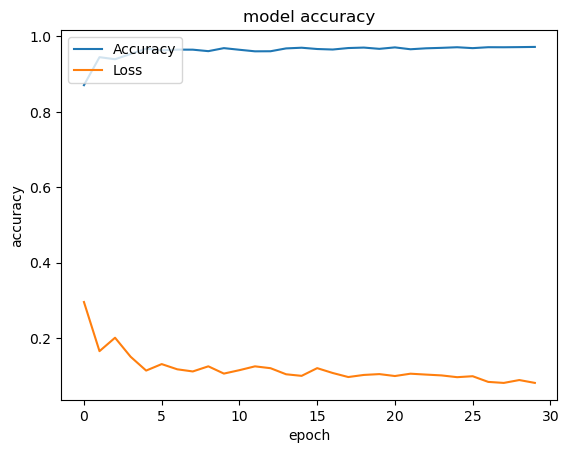

In [78]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

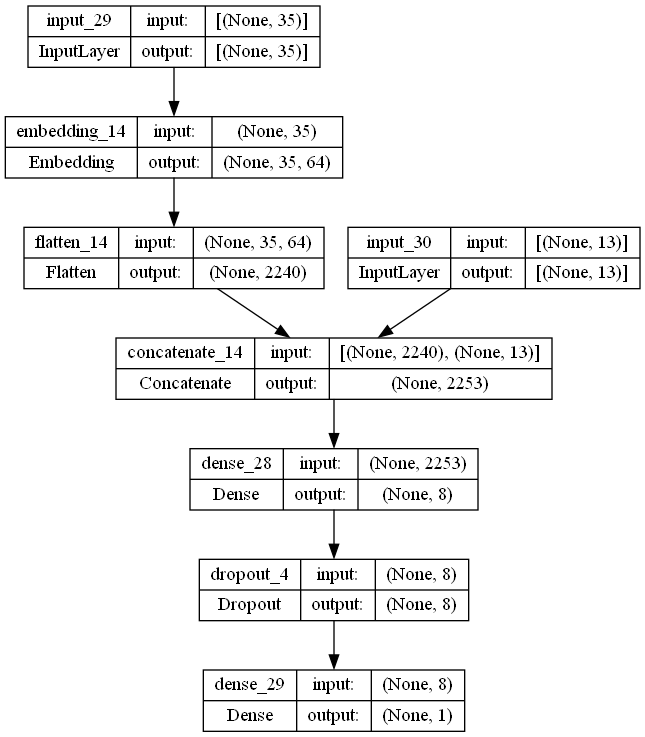

In [47]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [100]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
